
<center> <h1> Do Schools Really Consider Students’ Success  </center>
<center> <h1>When Allocating Expenditures?</h1> </center>
<center> <h2>Group “SASI & Co”: </h2> </center>
<center> <h2>Samuel Bull, Aminata Sanogo, </h2> </center>
<center> <h2>Sabina Seredneva, Ian Ustanik</h2> </center>
<br>
<br>
<center> <h3>IST 718 – Big Data Analytics</h3> </center>
<center> <h3>5/21/2021</h3> </center>

#### Contents:
1. Data Sources
2. Cleaning (R Code)
3. Feature Engineering (R Code)
4. Data Visualization
5. Machine Learning Models
6. Logistic Regression
7. Random Forest
8. Best Model
9. K-means Clustering
10. Conclusion

# DATA SOURCES

##### 1. Annual survey of school systems financial tables 
Link - https://www.census.gov/programs-surveys/school-finances/data/tables.html 
- Choose years 2010 - 2018
- Download 'All Data Items' file for each year

##### 2. ED Data Express: Percentage of students who graduated with a regular high school diploma
Link - https://eddataexpress.ed.gov/dashboard/title-i-part-a 
- Click 'Data Download Tool' in the top right corner
- Select all years between 2010-2018 in filters
- Click 'Download data' in the bottom right corner

##### 3. National Center for Educational Statistics: Public high school 4-year adjusted cohort graduation rate (ACGR)
Link - https://nces.ed.gov/programs/digest/d19/tables/dt19_219.46.asp 
- Numbers were entered manually into our final dataset

[**DOWNLOAD ALL RAW FILES**](https://drive.google.com/file/d/19iX8MlyjyNowcyL-ftI6t64L6tv1y7mU/view?usp=sharing)

[**DOWNLOAD TECHNICAL FILE FOR METADATA(PAGE 17)**](https://www.census.gov/programs-surveys/school-finances/technical-documentation/complete/2019.html)

[**DOWNLOAD FINAL CLEAN FILE**](https://drive.google.com/file/d/1n9xDAKFha-ATeZmkqpagPQdySZdUymTC/view?usp=sharing)

# CLEANING (R Code)
*Input files:*
 - **Financial data:**
- elsec10.xls
- elsec11.xls
- elsec12.xls
- elsec13.xls
- elsec14.xls
- elsec15.xls
- elsec16.xls
- elsec17.xls
- elsec18.xls
 - **Graduation Rates data:**
- Data_Download_Tool.csv

*Output file:*
- ready_project_dataset3.csv

## The code below was performed in R. 
#### Click the cell to see proper format!

***
library(tidyverse)
library(readxl)

#### 1. Load financial data ####

df10 <- read_excel("~/elsec10.xls")
df11 <- read_excel("~/elsec11.xls")
df12 <- read_excel("~/elsec12.xls")
df13 <- read_excel("~/elsec13.xls")
df14 <- read_excel("~/elsec14.xls")
df15 <- read_excel("~/elsec15.xls")
df16 <- read_excel("~/elsec16.xls")
df17 <- read_excel("~/elsec17.xls")
df18 <- read_excel("~/elsec18.xls")

#Merge all years data in one dataset (all tables have the same format)

financedata <- df10 %>%
  bind_rows(df11)%>%
  bind_rows(df12)%>%
  bind_rows(df13)%>%
  bind_rows(df14)%>%
  bind_rows(df15)%>%
  bind_rows(df16)%>%
  bind_rows(df17)%>%
  bind_rows(df18)

#### 2. Clean financial dataset ####

financedata <- financedata%>%
  mutate(year = paste('20',YRDATA, sep = ''))%>%
  mutate(year = as.numeric(as.character(year)))%>%  #change data type of the column 'year'
  rename(GEOID = 'NCESID')%>%
  mutate(oldGEOID = GEOID)%>%
  mutate(GEOID = as.numeric(as.character(GEOID)))  #change data type

#### 3. Load graduation rates data #### 

gradrate <- read.csv("~/Data_Download_Tool.csv")

#### 4. Clean graduation rates data #### 

gradrate <- gradrate%>%
  mutate(year = substr(School.Year, 1, 4))  #extract start of school year as 'year' column

gradrate <- gradrate%>%
  mutate(year = as.numeric(as.character(year)))  #change data type of the column 'year'

gradrate <- gradrate%>%
  rename(GEOID = "NCES.LEA.ID")%>% #change name of column to be consistent with other datasets
  select(c(State,GEOID, Value, Number.of.Valid.Test.Takers, year)) #select column that are needed
  
  
#### 5. Join financial and graduation rates data #### 

#Use inner join to exclude missing data in the output 

finance_grad <- financedata%>%   
  inner_join(gradrate, by = c("year","GEOID"))  #use year and unique GEOID for joinin 2 datasets

#### 6. Manually include national averages #### 

#Use 2017 national average for 2018 

finance_grad <- finance_grad%>%
  mutate(US_ACGR = NA)
  
finance_grad$US_ACGR[which(finance_grad$year == 2010)] <- 79
finance_grad$US_ACGR[which(finance_grad$year == 2011)] <- 80
finance_grad$US_ACGR[which(finance_grad$year == 2012)] <- 81
finance_grad$US_ACGR[which(finance_grad$year == 2013)] <- 82
finance_grad$US_ACGR[which(finance_grad$year == 2014)] <- 83
finance_grad$US_ACGR[which(finance_grad$year == 2015)] <- 84
finance_grad$US_ACGR[which(finance_grad$year == 2016)] <- 85
finance_grad$US_ACGR[which(finance_grad$year == 2017)] <- 85
finance_grad$US_ACGR[which(finance_grad$year == 2018)] <- 85

#### 7. Clean graduation rate ('Value') of each district #### 

finance_grad <- finance_grad%>%
  mutate(valueOLD = Value)

#Remove all letters from the strings

finance_grad$Value <- str_replace(finance_grad$Value, pattern = "[A-Z]+", replacement = "") 

#Remove some special signs found in the column

finance_grad$Value <- str_replace(finance_grad$Value, pattern = ">", replacement = "")
finance_grad$Value <- str_replace(finance_grad$Value, pattern = "<", replacement = "")
finance_grad$Value <- str_replace(finance_grad$Value, pattern = "=", replacement = "")

#As some cells include range, sivide column into 2 columns

finance_grad <- finance_grad%>%
  separate(Value,c("1st","2nd"),"-")

#Create new empty column for final graduation rate value

finance_grad <- finance_grad%>%
  mutate(FinalValue = NA)

#Change data type to numbers

finance_grad <- finance_grad%>%
  mutate(`1st` = as.numeric(as.character(`1st`)))%>%
  mutate(`2nd` = as.numeric(as.character(`2nd`)))

#Use For loop to define final value for graduation rate
#If value contained one number, then during splitting into 2 column the 2nd value was NA. So, if 2ns column contain NA then #include 1st column value as FinalValue
#If first condition is not the case then include mean of the 1st and 2nd column (mean of the range)

for(myrows in c(1:96763)){
  if(is.na(finance_grad$`2nd`[myrows])){
    finance_grad$FinalValue[myrows] <- finance_grad$`1st`[myrows]
  } else {
    finance_grad$FinalValue[myrows] <- mean(finance_grad$`1st`[myrows]:finance_grad$`2nd`[myrows])
  }
}

#Exclude missing values

finance_grad <- finance_grad%>%
  filter(!is.na(FinalValue))
  
#Choose columns needed

finance_grad <- finance_grad%>%
  select(!c(1,9, 143,145,146,149))  #choose columns needed



# FEATURE ENGINEERING (R Code)

#### 8. Create graduation class  (1 if above national average, 0 if below) #### 

#Create empty column

finance_grad <- finance_grad%>%
  mutate(Grad_Rate_Class = NA)

#Perform comparison analysis for each row usin For loop

for(myrows in c(1:95253)){
  if(is.na(finance_grad$FinalValue[myrows]) | is.na(finance_grad$US_ACGR[myrows])){
    finance_grad$Grad_Rate_Class[myrows] <- NA
  } else if(finance_grad$FinalValue[myrows] >= finance_grad$US_ACGR[myrows]){
    finance_grad$Grad_Rate_Class[myrows] <- 1
  } else {
    finance_grad$Grad_Rate_Class[myrows] <- 0
  }
}


#### 9. Create dummy variables #### 
library(fastDummies)
memory.limit(size=12000)

###### CONUM ######

conum <- finance_grad%>%         
  select(c(GEOID,year,CONUM))%>%
  mutate(CONUM = as.character(CONUM))%>%
  dummy_cols()%>%
  select(!c(3,4))

###### SCHLEV ######

schlev <- finance_grad%>%       
  select(c(GEOID, year, SCHLEV))%>%
  dummy_cols()%>%
  select(!c(3,4))
  
###### STATES ######  
  
statesd <- finance_grad%>%   
  select(c(GEOID, year, State))%>%
  dummy_cols()%>%
  select(!c(3,4))


#### 10. Calculate ratios #### 

###### Ratios of  valid test takers from total fall membership ('V33' column - number of students) ###### 

students <- finance_grad%>%        
  select(c(GEOID, year, V33, Number.of.Valid.Test.Takers))%>%
  rename(fall_membership = 'V33')%>%
  filter(!fall_membership == 0)%>%
  mutate(TestTakersRatio = Number.of.Valid.Test.Takers/fall_membership)%>%
  select(!c(4))
 
###### Ratios of revenue elements from total revenue ######  
 
revenue <- finance_grad%>%   
  select(c(7, 140,9,11:22,24:38,40:60))%>%
  mutate(across(c(C14:U97),
                .fns = ~./TOTALREV))
                
###### Ratios of expenditure elements from total expendutire ######   
                        
expend <- finance_grad%>%      
  select(c(7,140, 61,64:69,71:87,89:93,95:98,100:130))%>%
  mutate(across(c(E13:V32),
                .fns = ~./TOTALEXP))


#### 11. Extract whole numbers & class #### 

##### Balance Sheet elements ######

balancesheet <- finance_grad%>%  
  select(c(7,140,131:139))

###### Graduation class ######

gradclass <- finance_grad%>%       
  select(c(GEOID, year, Grad_Rate_Class))
  
 
###### IDCENSUS ######

idcensus <- finance_grad%>%           
  select(c(GEOID, year, IDCENSUS)) 
  
#### 12. Join clean datasets #### 

finaldata <- idcensus%>%
  left_join(statesd, by = c('GEOID','year'))%>%
  left_join(conum, by = c('GEOID','year'))%>%
  left_join(schlev, by = c('GEOID','year'))%>%
  left_join(students, by = c('GEOID','year'))%>%
  left_join(revenue, by = c('GEOID','year'))%>%
  left_join(expend, by = c('GEOID','year'))%>%
  left_join(balancesheet, by = c('GEOID','year'))%>%
  left_join(gradclass, by = c('GEOID','year'))

###### Exclude missing data & repetitive rows ######

finaldata <- finaldata%>%
  distinct()%>%
  filter(!is.na(C14))%>%
  filter(!is.na(E13))%>%
  filter(!is.na(TestTakersRatio))

###### Transform whole numbers from thousands $ to $ ######

finaldata <- finaldata%>%      
  mutate(across(c(TOTALREV,TOTALEXP,X_19H, X_21F, X_31F,X_41F,X_61V, X_66V, W01, W31, W61),
                .fns = ~.*1000))

#### 13. Clean column names #### 

library(janitor)
finaldata <- finaldata%>%
  clean_names()
  
#### Save final file ####
write.csv(finaldata,"~/ready_project_dataset3.csv", row.names = FALSE)



In [1]:
# Load the packages
# create spark and sparkcontext objects
import pyspark
from pyspark import sql
from pyspark.sql import SparkSession
from pyspark.sql import types, functions as fn, Row
from pyspark.ml import feature, regression, evaluation, Pipeline, pipeline, tuning, clustering, classification
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset and view the structure of it
ready_project_dataset = spark.read.csv('ready_project_dataset3.csv', inferSchema=True, header=True)
ready_project_dataset.printSchema()

root
 |-- geoid: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- idcensus: double (nullable = true)
 |-- state_alaska: integer (nullable = true)
 |-- state_arizona: integer (nullable = true)
 |-- state_arkansas: integer (nullable = true)
 |-- state_california: integer (nullable = true)
 |-- state_colorado: integer (nullable = true)
 |-- state_connecticut: integer (nullable = true)
 |-- state_delaware: integer (nullable = true)
 |-- state_district_of_columbia: integer (nullable = true)
 |-- state_florida: integer (nullable = true)
 |-- state_georgia: integer (nullable = true)
 |-- state_hawaii: integer (nullable = true)
 |-- state_idaho: integer (nullable = true)
 |-- state_illinois: integer (nullable = true)
 |-- state_indiana: integer (nullable = true)
 |-- state_iowa: integer (nullable = true)
 |-- state_kansas: integer (nullable = true)
 |-- state_kentucky: integer (nullable = true)
 |-- state_louisiana: integer (nullable = true)
 |-- state_maine: integer (nullab

# Data Visualization

In [3]:
ready_project_dataset.groupBy('grad_rate_class').count().toPandas()

,grad_rate_class,count
0,1,63685
1,0,30862


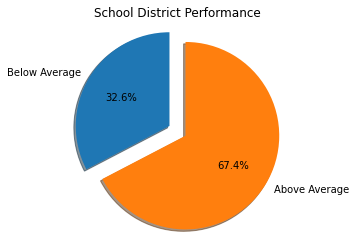

In [4]:
# Pie chart for classes
labels = 'Below Average', 'Above Average'
sizes = [30862, 63685]
explode = (0.2, 0)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title("School District Performance")

plt.show()

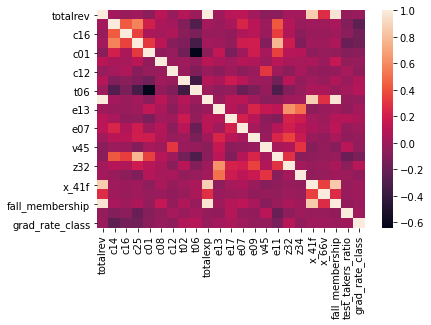

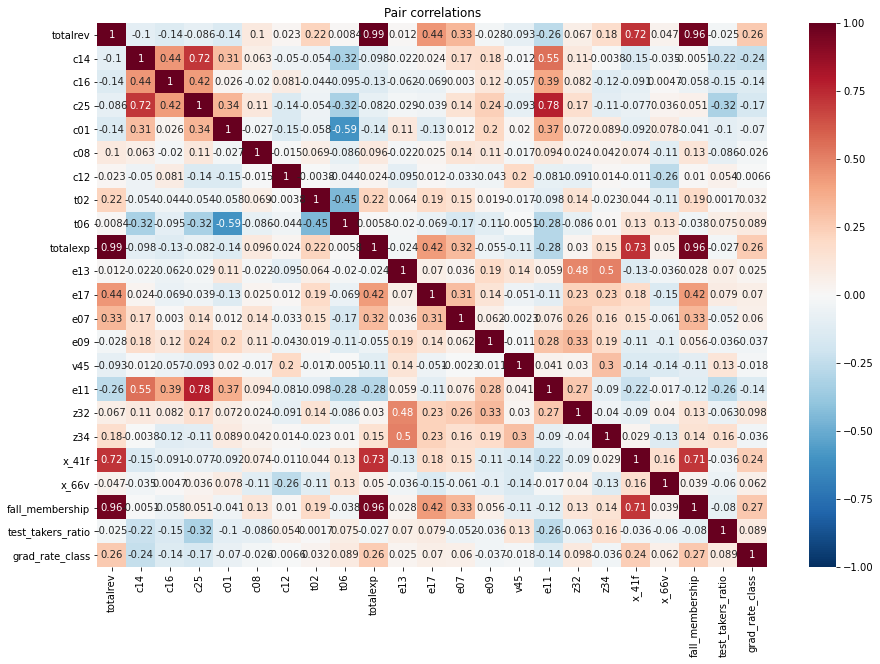

In [5]:
# Pair correlation matrix

# choose columns to analyze
finaldata1 = ready_project_dataset.dropna().select('totalrev','c14','c16','c25','c01','c08','c12','t02','t06',
                                                   'totalexp','e13','e17','e07','e09','v45','e11',
                                                   'z32','z34','x_41f','x_66v','fall_membership','test_takers_ratio','grad_rate_class')

finaldata1 = finaldata1.toPandas()

#plot the matrix
plt.plot(figsize=(30,30))
sns.heatmap(finaldata1.corr())

R = finaldata1.corr(method='spearman')
plt.figure(figsize=(15, 10))
sns.heatmap(R, vmin=-1, vmax=1, cmap='RdBu_r', annot=True)
plt.title('Pair correlations')
plt.show()

# CREATE MACHINE LEARNING MODELS

In [6]:
# Drop columns that are not used in the model
# Drop missing values, if there is any
ready_project_dataset = ready_project_dataset.\
    drop('geoid').\
    drop('year').\
    drop('idcensus').\
    dropna()

In [7]:
# Rename output column
ready_project_dataset = ready_project_dataset.withColumnRenamed('grad_rate_class','label')

# Split data into training, validation, and testing datasets
training_df, validation_df, testing_df = ready_project_dataset.randomSplit([0.6, 0.3, 0.1], seed=0)

# View the size of updated data
print('Number of rows:' , (ready_project_dataset.count()))
print('Number of columns:', len(ready_project_dataset.columns))

Number of rows: 94547
Number of columns: 3295


In [8]:
# View the number of observations per dataset
[training_df.count(), validation_df.count(), testing_df.count()]

[56693, 28398, 9456]

In [9]:
# Combining all features values into one vector (per observation) through Vector Assembler 
va = VectorAssembler().setInputCols(training_df.columns[0:3293]).setOutputCol('features')

# LOGISTIC REGRESSION ANALYSIS (LASSO)

In [10]:
# Set the parameters for the model
lr = classification.LogisticRegression().setFeaturesCol('features').setLabelCol('label').\
    setPredictionCol('prediction').setMaxIter(100).setRegParam(0.01).setElasticNetParam(1)

# Create a pipeline
lr_pipeline1 = Pipeline(stages=[va,lr]).fit(training_df)

###### Parameters of the model:
1. Setting Elastic Net Parameter (alpha) as 1 creates a lasso regression which selects more relevant features and discards the others by penalizing the number of features to control overfitting.
2. Setting Regularization parameter (lambda) to 0.01 to control the learning rate. The number shows how much we want the model to change during each iteration of leraning. The optimal value was found through trial and error.
3. Setting Max Iteration parameter to 100 to control the number of times the model should be iterated to learn. The optimal value was found through trial and error.

In [11]:
# Calculate area under the ROC curve to evaulate performance of the model on validation dataset

#define the bce function
bce = BinaryClassificationEvaluator()

#evaluate auc
AUC1 = bce.evaluate(lr_pipeline1.transform(validation_df))

# print the auc
print("Logistic Regression Model AUC:", AUC1)

Logistic Regression Model AUC: 0.8417529625672914


The AUC of this model, after we tested and tuned parameters, comes out to be about 0.842, which is decently accurate considering the values we recieved initially (ranging from 0.3-0.5) and the scale of our dataset.  

In [12]:
# Calculate the elements of the confusion matrix
prediction_lr = lr_pipeline1.transform(validation_df)
TN_lr = prediction_lr.filter('prediction = 0 AND label = prediction').count()
TP_lr = prediction_lr.filter('prediction = 1 AND label = prediction').count()
FN_lr = prediction_lr.filter('prediction = 0 AND label <> prediction').count()
FP_lr = prediction_lr.filter('prediction = 1 AND label <> prediction').count()

In [13]:
# Calculate additional evaluation metrics
accuracy_lr = (TN_lr + TP_lr) / (TN_lr + TP_lr + FN_lr + FP_lr)
precision_lr = TP_lr / (TP_lr + FP_lr)
recall_lr = TP_lr / (TP_lr + FN_lr)
F_lr =  2 * (precision_lr*recall_lr) / (precision_lr + recall_lr)
print('Logistic regression additional metrics')
print('precision: %0.3f' % precision_lr)
print('recall: %0.3f' % recall_lr)
print('accuracy: %0.3f' % accuracy_lr)
print('F1 score: %0.3f' % F_lr)

Logistic regression additional metrics
precision: 0.788
recall: 0.919
accuracy: 0.778
F1 score: 0.848


In [14]:
# Feature importance of the Logistic Regression model
cols = ready_project_dataset.columns[0:3293]
feature_importance = pd.DataFrame(list(zip(cols, lr_pipeline1.stages[-1].\
                                        coefficients.toArray())), columns = ['feature', 'importance']).\
                                  sort_values('importance')

In [15]:
print(feature_importance)

     feature  importance
3268     v15  -30.419708
3273     v29  -19.896223
3230     e08  -13.437428
3173     c14  -11.779298
3272     v37  -10.672188
...      ...         ...
3265     z33    3.236728
3241     j45   14.089076
3211     a11   23.882118
3237     j07   27.278845
3210     a09   82.846163

[3293 rows x 2 columns]


#### Here are the top 5 variables that POSITIVELY affect Grad_Rate_Class
-	A09: School lunch revenues
-	J07:  State payments on behalf - Instructional staff support benefits
-	A11: Textbook sales and rentals
-	J45: State payments on behalf - Student transportation benefits
-	Z33: Total salaries and wages - Instruction 

#### Here are the top 5 variables that NEGATIVELY affect Grad_Rate_Class
-   V15: Total salaries and wages - General administration
-	V29: Total salaries and wages - Food services
-	E08: Current operation expenditure - General administration
-	C14:  Federal revenue through the state - Title I
-	V37: Total salaries and wages - Business/central/other support services

# RANDOM FOREST EVALUATION
We used random forest as a classification method because it maintained the accuracy of a large proportion of our data. The random forest classification used bagging and randomness when creating the individual trees to create the uncorrelated forest of trees whose prediction is more accurate then an individual tree.  We used the default number of decision trees, 20 trees in the initial  analysis. Then changed the number of trees to 100, then our accuracy increased. Through trial and error, we observed that the number of trees that resulted in the best accuracy  it our data was 135 trees.

In [47]:
#RANDOM FOREST MODEL

# Define random forest function
rf = RandomForestClassifier(numTrees = 135)

# Create pipeline using previously defined vectorAssembler stage and random forest function
rf_pipeline = Pipeline(stages=[va, rf]).fit(training_df)

In [48]:
# Calculate area under the ROC curve to evaulate performance of the model on validation dataset

# Evaluate AUC using previously defined bce
AUC2 = bce.evaluate(rf_pipeline.transform(validation_df))

# Print AUC
print("Random Forest Model AUC:", AUC2)

Random Forest Model AUC: 0.8502106391148065


In [49]:
# Calculate the elements of the confusion matrix
prediction_rf = rf_pipeline.transform(validation_df)
TN_rf = prediction_rf.filter('prediction = 0 AND label = prediction').count()
TP_rf = prediction_rf.filter('prediction = 1 AND label = prediction').count()
FN_rf = prediction_rf.filter('prediction = 0 AND label <> prediction').count()
FP_rf = prediction_rf.filter('prediction = 1 AND label <> prediction').count()

In [50]:
# Calculate additional evaluation metrics
accuracy_rf = (TN_rf + TP_rf) / (TN_rf + TP_rf + FN_rf + FP_rf)
precision_rf = TP_rf / (TP_rf + FP_rf)
recall_rf = TP_rf / (TP_rf + FN_rf)
F_rf =  2 * (precision_rf*recall_rf) / (precision_rf + recall_rf)
print('Random forest additional metrics')
print('precision: %0.3f' % precision_rf)
print('recall: %0.3f' % recall_rf)
print('accuracy: %0.3f' % accuracy_rf)
print('F1 score: %0.3f' % F_rf)

Random forest additional metrics
precision: 0.726
recall: 0.986
accuracy: 0.740
F1 score: 0.836


In [57]:
# view feature importance of random forest model
rf_model = rf_pipeline.stages[-1]
df=pd.DataFrame(list(zip(ready_project_dataset.columns[0:3293], rf_model.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending = False)
df

,column,weight
3221,totalexp,0.068905
3172,totalrev,0.067852
3170,fall_membership,0.062731
3210,a09,0.056407
3268,v15,0.048611
...,...,...
1198,conum_22089,0.000000
1199,conum_22091,0.000000
1200,conum_22093,0.000000
1201,conum_22095,0.000000


#### Here are the top 5 variables that affect Grad_Rate_Class the most
-	totalexp: Total elementary-secondary expenditure
-	totalrev: Total elementary-secondary revenue
-   fall_membership: Number of students of fall cohort
-   a09: School lunch revenues
-   v15: Total salaries and wages - General administration 

#### The least important variable in the model
-    'conum' dummy variables: ANSI State and County Code

# BEST MODEL

#### Compraring evaluation metrics
AUC - the area under the ROC Curve - defines how good our model is. AUC provides an aggregate measure of performance across all possible classification thresholds. 
The Random Forest model has higher AUC at the level 0.8502 compared to 0.8417 of Logistic Regression.

The precision value, which is in place to show the ratio of correctly predicted positive observations to the number of overall predicted positive observations, gives us a value of about 0.726 for Random Forest and 0.788 Logistic Regression, which are pretty good in terms of the system doing its job.
The Logistic Regression model has better precision.

The recall value, which shows the ratio of correctly predicted positive observations to all observations (i.e. all true positives and false negatives), gives us a value of about 0.986 for Random Forest and 0.919 for Logistic Regression, which are also at a very high level.
The Random Forest model has better recall.

The F1-score value, which is basically just the weighted average of both the precision and recall values, come out to be about 0.848 for Logistic Regression and 0.836 for Random Forest, which makes sense based on the previous values.
The Logistic Regression model has slightly better F1 score.

Finally, the accuracy of the predictiosn overall come out with an F1-score of 0.74 for Random Forest and 0.778 for Logistic Regression, which are less than we hoped from the pipeline created above the report, but again falls in line with the results from the rest of the report. 
The Logistic Regression model has better accuracy.

#### The AUC value was used to determine best model - Random Forest

In [58]:
TestAUC = bce.evaluate(rf_pipeline.transform(testing_df))
print("Testing data AUC:", TestAUC)

Testing data AUC: 0.8452771995966678


With the evaluated "Aera Under the Curve" value of the testing dataframe coming out to be about 0.845, we can detremine that the Random Forest model has a high predictive power. 

In [59]:
# Calculate the elements of the confusion matrix
prediction_rf2 = rf_pipeline.transform(testing_df)
TN_rf2 = prediction_rf2.filter('prediction = 0 AND label = prediction').count()
TP_rf2 = prediction_rf2.filter('prediction = 1 AND label = prediction').count()
FN_rf2 = prediction_rf2.filter('prediction = 0 AND label <> prediction').count()
FP_rf2 = prediction_rf2.filter('prediction = 1 AND label <> prediction').count()

In [61]:
# Calculate additional evaluation metrics
accuracy_rf2 = (TN_rf2 + TP_rf2) / (TN_rf2 + TP_rf2 + FN_rf2 + FP_rf2)
precision_rf2 = TP_rf2 / (TP_rf2 + FP_rf2)
recall_rf2 = TP_rf2 / (TP_rf2 + FN_rf2)
F_rf2 =  2 * (precision_rf2*recall_rf2) / (precision_rf2 + recall_rf2)
print('Random forest additional metrics on testing dataset')
print('precision: %0.3f' % precision_rf2)
print('recall: %0.3f' % recall_rf2)
print('accuracy: %0.3f' % accuracy_rf2)
print('F1 score: %0.3f' % F_rf2)

Random forest additional metrics on testing dataset
precision: 0.721
recall: 0.986
accuracy: 0.735
F1 score: 0.833


Each of the values we wanted to zero in on (i.e. the precision, recall, and the accuracy value) came out to be high. With that being said, these values prove the validity and the accuarcy of the Random Forest model we created.

With values above 0.7, we determined that the prediction of whether or not a school districts met the standards we set was very good considering the size and scope of the dataset(s) we utilized. 

## CLUSTERING

In [62]:
# Load data for clustering
schools_df = ready_project_dataset

In [63]:
# Exclude CONUM data about state code and county number for better performance of analysis
feature_list = schools_df.columns
feature_list = [x for x in feature_list if not x.startswith('conum')]

#### Silhouette Analysis:
The team took advantage of a silhouette analysis to determine the optimal number of clusters to use as a parameter for K-means clustering. Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters.

In [64]:
# Created pipeline schools_clustering
silhouette_list = [] # Created empty silhouette list
n_list = [] # Created empty n list
for n in range(5,100, 5): # For each fifth value from 5 to 100:
    va = feature.VectorAssembler(inputCols=feature_list, outputCol='features') # Created VectorAssembler pipeline stage for converting features in feature_list to a single features vector
    km = clustering.KMeans(k = n, featuresCol='features', predictionCol='prediction') # Created KMeans pipeline stage where k = n from the features column, with each prediction cluster output to a predictions column
    pipe = Pipeline(stages=[va, km]) # Created pipeline estimator with va and km stages
    schools_clustering = pipe.fit(schools_df) # Fit pipeline to schools_df dataset, assigned to schools_clustering
    clustered = schools_clustering.transform(schools_df) # Returned clustered dataframe
    
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(clustered) # Produced silhouette score
    print("Silhouette with squared euclidean distance = " + str(silhouette), "n: ",  n) # Printed silhouette score and n value
    silhouette_list.append(silhouette) # Appended score to silhouette list
    n_list.append(n) # Appended n to n list

Silhouette with squared euclidean distance = 0.9456512102161518 n:  5
Silhouette with squared euclidean distance = 0.7897502089221566 n:  10
Silhouette with squared euclidean distance = 0.7006631341816474 n:  15
Silhouette with squared euclidean distance = 0.6741736580958748 n:  20
Silhouette with squared euclidean distance = 0.6167843259104211 n:  25
Silhouette with squared euclidean distance = 0.5533081230773949 n:  30
Silhouette with squared euclidean distance = 0.6203863914138692 n:  35
Silhouette with squared euclidean distance = 0.5358436924510789 n:  40
Silhouette with squared euclidean distance = 0.5900162249035185 n:  45
Silhouette with squared euclidean distance = 0.5377220809296827 n:  50
Silhouette with squared euclidean distance = 0.5289100420742036 n:  55
Silhouette with squared euclidean distance = 0.5688673867220992 n:  60
Silhouette with squared euclidean distance = 0.518976207221511 n:  65
Silhouette with squared euclidean distance = 0.4904214299508904 n:  70
Silhouet

In [65]:
dic = dict(zip(n_list, silhouette_list)) # Created dictionary of n values with their respective silhouette score

In [66]:
dic # Returned dictionary

{5: 0.9456512102161518,
 10: 0.7897502089221566,
 15: 0.7006631341816474,
 20: 0.6741736580958748,
 25: 0.6167843259104211,
 30: 0.5533081230773949,
 35: 0.6203863914138692,
 40: 0.5358436924510789,
 45: 0.5900162249035185,
 50: 0.5377220809296827,
 55: 0.5289100420742036,
 60: 0.5688673867220992,
 65: 0.518976207221511,
 70: 0.4904214299508904,
 75: 0.422634005213112,
 80: 0.4900675797976242,
 85: 0.4851356121034407,
 90: 0.44594228142474346,
 95: 0.46268778265713745}

In [67]:
max_n = max(dic, key=dic.get) # Returned max n value from dictionary

In [68]:
max(silhouette_list) # Returned maximum silhouette score from silhouette list

0.9456512102161518

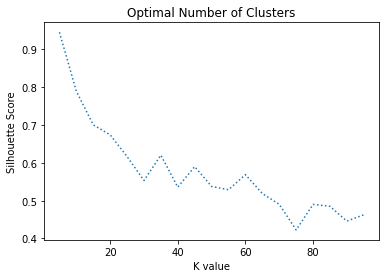

In [69]:
# Plotted optimal number of clusters based on silhouette score results
plt.plot(n_list, silhouette_list, linestyle = 'dotted')
plt.xlabel('K value')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.show()

#### K-means Clustering Analysis:
The team then used the highest value for k returned from the silhouette analysis in order to produce the most distinct clusters and to compare the features of similarly performing schools. We then analyzed cluster results which grouped together schools which had similar values for important features. 

In [70]:
va = feature.VectorAssembler(inputCols=feature_list, outputCol='features') # Created VectorAssembler pipeline stage for converting features in feature_list to a single features vector
km = clustering.KMeans(k = max_n, featuresCol='features', predictionCol='prediction') # Created KMeans pipeline stage where k = n with highest silhouette score from the features column, with each prediction cluster output to a predictions column
pipe = Pipeline(stages=[va, km]) # Created pipeline estimator with va and km stages
schools_clustering = pipe.fit(schools_df) # Fit pipeline to schools_df dataset, assigned to schools_clustering

In [71]:
clustered = schools_clustering.transform(schools_df) # Returned transformed dataframe using schools_clustering pipeline

In [75]:
# Created dataframe cluster_analysis
cluster_analysis = clustered.groupby(['prediction', 'label']).count() # Created dataframe with the count of each cluster using the groupby() function
cluster_analysis = cluster_analysis.withColumnRenamed('count','n_schools') # Renamed the count column to n_schools
cluster_analysis = cluster_analysis.withColumnRenamed('prediction','cluster') # Renamed the prediction column to cluster
cluster_analysis = cluster_analysis.orderBy(fn.col('cluster').asc()) # Ordered by cluster ascending
cluster_analysis.show(truncate = False) # Viewed resulting dataframe

+-------+-----+---------+
|cluster|label|n_schools|
+-------+-----+---------+
|0      |1    |61310    |
|0      |0    |29507    |
|1      |0    |9        |
|2      |1    |5        |
|2      |0    |35       |
|3      |0    |1210     |
|3      |1    |2225     |
|4      |0    |101      |
|4      |1    |145      |
+-------+-----+---------+



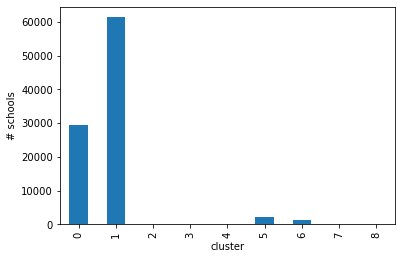

In [76]:
# Plotted the results
(cluster_analysis
 .toPandas()
 .sort_values('cluster')
 .reset_index()
 .n_schools.plot(y='n_schools', kind='bar')
);
plt.xlabel('cluster')
plt.ylabel('# schools');

In [77]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(clustered) # Produced silhouette score
print("Silhouette with squared euclidean distance = " + str(silhouette)) # Printed silhouette score and n value

# Showing the result
centers = schools_clustering.stages[-1].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.9456512102161518
Cluster Centers: 
[4.53659557e-03 1.12093551e-02 2.32005021e-02 3.58853519e-02
 1.55807833e-02 1.15066562e-02 1.82785161e-03 0.00000000e+00
 4.21727210e-03 1.63956088e-02 0.00000000e+00 7.02511644e-03
 4.09614940e-02 2.80454100e-02 3.09523547e-02 2.72636180e-02
 1.27399055e-02 5.89096755e-03 1.05266635e-02 1.35437198e-03
 2.47420637e-02 4.99686182e-02 3.11175220e-02 1.42704560e-02
 4.30315910e-02 1.40282106e-02 2.37290375e-02 1.38740544e-03
 7.44354031e-03 2.75058634e-02 8.32443265e-03 6.23451556e-02
 1.02513847e-02 1.35877644e-02 5.96254005e-02 3.15910017e-02
 1.67259434e-02 4.81297554e-02 3.07211205e-03 6.84893797e-03
 1.45127014e-02 1.13745224e-02 8.77258663e-02 2.24627548e-03
 4.55861788e-03 1.17819351e-02 2.17470297e-02 5.43951022e-03
 3.70415231e-02 4.19524979e-03 3.76471365e-02 9.51903278e-01
 6.95904952e-03 1.10111543e-05 1.10111543e-05 2.56477816e+03
 8.45795071e-02 3.36930152e+07 2.08126223e-02 1.27436782e-02
 2.

In [78]:
# Example clustering results
test = clustered.where(fn.col('prediction') == 0)
test = test.select(fn.col('totalrev'),fn.col('totalexp'), fn.col('label'), fn.col('prediction'))
test.show()

+---------+---------+-----+----------+
| totalrev| totalexp|label|prediction|
+---------+---------+-----+----------+
| 7.5102E7| 8.1788E7|    1|         0|
| 1.1335E7| 1.3032E7|    0|         0|
| 2.6377E7| 2.6929E7|    0|         0|
| 3.3635E7| 3.6769E7|    0|         0|
|  6.636E7| 6.6898E7|    1|         0|
| 1.1747E7| 1.1862E7|    1|         0|
| 1.6261E7| 1.6748E7|    0|         0|
| 3.1815E7| 3.2148E7|    0|         0|
| 2.5466E7| 2.5613E7|    0|         0|
| 8.4983E7|  8.176E7|    0|         0|
| 1.4282E7| 1.4155E7|    1|         0|
| 1.0512E7| 1.0296E7|    1|         0|
| 5.6452E7| 5.5522E7|    1|         0|
| 3.6605E7|  3.806E7|    1|         0|
|8470000.0|8463000.0|    0|         0|
|  3.787E7| 4.0308E7|    0|         0|
| 6.2323E7| 6.3721E7|    0|         0|
| 2.0229E7| 2.2262E7|    0|         0|
| 3.0904E7| 3.1652E7|    0|         0|
|  1.354E7| 1.3732E7|    1|         0|
+---------+---------+-----+----------+
only showing top 20 rows



# CONCLUSION

#### Insights from 2 models feature importance
-   A09: School lunch revenues. The higher the ratio of this element from total revenue the better school is performing. This part of revenue comes from Local Sources according to metadata provided by Census. It makes sense if students are eating well they can focus better on studies.
-   V15: Total salaries and wages - General administration. The higher the ratio of this expenditure from total expenditure the worse the performance of school is. Here we see high correlation, however, we don't know whether there is real causation between spendings on general administration and performace of students. Logically, it makes sense that there is should be expenditure on general administration of school.But at one point there could be a situation when ab additional administration staff will not bring value and will be a waste of resource

#### Insights from Random Forest feature importance
-   totalexp: Total elementary-secondary expenditure.  This makes sense as the more resources school has the better performance of students would be.
-   totalrev: Total elementary-secondary revenue. This makes sense as the more school spends on students the better their performance would be.
-   fall_membership: Number of students of fall cohort. The sign (positive/negative) for this feature is not defined as the variable has 0 weight in Logistic regression model. However, in Random forest model the variable has high importance. Here could be 2 explanations. First, the higher number of students in school the worse graduating students perform as resources have to be more splitted among different groups/grades. Second, the higher total number of students the better graduating students perform as being a part of a big cohort they feel bigger motivation to differentiate themselves in order to get into college/start a career.